In [1]:
#Import all the necessary libraries

import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.metrics import classification_report

# Data Fake News Detection (Fakenewsnet)

## Import & basic cleaning

### Import Data

In [2]:
pol_real=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/politifact_HR.json", orient='index')
pol_real.head()

,id,text,title,description
0,politifact8769,"The award-winning, nonpartisan intel you can t...",Legislative Tracking Software,Track federal legislation with expert policy a...
1,politifact12052,"At the CNN debate in Miami, GOP candidates spa...","The CNN Miami Republican debate transcript, an...",Washington Post reporters add insight and anal...
2,politifact4858,It’s that time of year again – white elephant ...,Mitt v Mitt,"Yup, Mitt vs Mitt aja. Rame!"
3,politifact10945,"Thank you! Oh, thank you all! Thank you so ver...",Hillary Clinton Transcript: Read Full Text of ...,Hillary Clinton held the first major rally of ...
4,politifact14511,Maddow on Trump indictment: 'He knew it was wr...,'Discriminatory animus': Trump sued on DACA,New York Attorney General Eric Schneiderman ta...


In [3]:
pol_fake=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/politifact_HF.json", orient='index')
pol_fake.head()

,id,text,title,description
0,politifact11773,Republican attacks on transgendered Americans ...,Virginia Republican Wants Schools To Check Chi...,Republican attacks on transgendered Americans ...
1,politifact13827,Whoopi Goldberg is in hot water after comments...,Whoopi Goldberg: Navy SEAL Widow was “Looking ...,Whoopi Goldberg is in hot water after comments...
2,politifact13570,"Washington, DC — A former Secret Service agent...",Secret Service Agent Says Obama Is Muslim & Ga...,"Washington, DC — A former Secret Service agent..."
3,politifact14947,Bill Clinton’s hitman has confessed to more th...,Bill Clinton’s Hitman Confesses On His Deathbe...,Bill Clinton’s hitman has confessed to more th...
4,politifact14517,About Trendolizer™\n\nTrendolizer™ (patent pen...,UPDATE: Florida Governor Rick Scott Now Listed...,Scott&#8217;s prognosis isn&#8217;t good. (via...


In [4]:
gossip_fake=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/gossip_HF.json", orient='index')
gossip_fake.head()

,id,text,title,description
0,gossipcop-1991455469,✕ Close Meghan Markle and Prince Harry have an...,As it happened: Prince Harry and Meghan Markle...,The wedding will take place in spring 2018
1,gossipcop-7798039260,Kim Kardashian and Kanye West are pulling out ...,Kim & Kanye Install At-Home Panic Room After P...,'Keeping the kids safe is the couples number o...
2,gossipcop-7817725290,Prince Harry and Meghan currently live at Kens...,£1.4million spent renovating Prince Harry and ...,Prince Harry and Meghan might not be living in...
3,gossipcop-5111151830,They can't get enough of the Biebs on this sho...,Photos from Dancing With the Stars: Special Gu...,Photos from Dancing With the Stars: Special Gu...
4,gossipcop-9658632569,Ben Affleck is keeping life with his three kid...,Jennifer Garner ‘Doesn’t Want’ Her Kids Around...,Jennifer Garner ‘doesn’t want’ her three kids ...


In [5]:
gossip_real=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/gossip_HR.json", orient='index')
gossip_real.head()

,id,text,title,description
0,gossipcop-951329,11 Summer Camp Movies That'll Make You Nostalg...,11 Summer Camp Movies That'll Make You Nostalg...,Nothing says summer like watching a movie all ...
1,gossipcop-861360,Info Category: Richest Business › Executives N...,Charrisse Jackson Jordan Net Worth,What is Charrisse Jackson Jordan's net worth?
2,gossipcop-911046,Warning: This story contains major spoilers fr...,Raúl Esparza exits Law & Order: SVU after six ...,The actor reveals why he decided to leave the ...
3,gossipcop-899120,Lil Peep died of an overdose of fentanyl and g...,Lil Peep Cause of Death Revealed,Pima County Office of the Medical Examiner con...
4,gossipcop-919455,Goop is kicking off its weekly podcast in a bi...,"Gwyneth Paltrow, Oprah talk Weinstein, #MeToo’...",Goop is kicking off its weekly podcast in a bi...


### Concat Data

In [6]:
print(pol_real.shape)
print(pol_fake.shape)
print(gossip_real.shape)
print(gossip_fake.shape)

(194, 4)
(97, 4)
(8168, 4)
(4084, 4)


In [7]:
pol_real["fake"]=0
pol_fake["fake"]=1
gossip_real["fake"]=0
gossip_fake["fake"]=1

In [8]:
data=pd.concat((pol_fake, pol_real, gossip_fake, gossip_real),axis=0, ignore_index=True)

In [9]:
data.shape

(12543, 5)

In [10]:
data.head()

,id,text,title,description,fake
0,politifact11773,Republican attacks on transgendered Americans ...,Virginia Republican Wants Schools To Check Chi...,Republican attacks on transgendered Americans ...,1
1,politifact13827,Whoopi Goldberg is in hot water after comments...,Whoopi Goldberg: Navy SEAL Widow was “Looking ...,Whoopi Goldberg is in hot water after comments...,1
2,politifact13570,"Washington, DC — A former Secret Service agent...",Secret Service Agent Says Obama Is Muslim & Ga...,"Washington, DC — A former Secret Service agent...",1
3,politifact14947,Bill Clinton’s hitman has confessed to more th...,Bill Clinton’s Hitman Confesses On His Deathbe...,Bill Clinton’s hitman has confessed to more th...,1
4,politifact14517,About Trendolizer™\n\nTrendolizer™ (patent pen...,UPDATE: Florida Governor Rick Scott Now Listed...,Scott&#8217;s prognosis isn&#8217;t good. (via...,1


In [11]:
data["fake"].value_counts()

fake
0    8362
1    4181
Name: count, dtype: int64

### Check for duplicates and missing values, remove duplicate texts

In [12]:
data[data.duplicated()]

,id,text,title,description,fake


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12543 entries, 0 to 12542
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           12543 non-null  object
 1   text         12543 non-null  object
 2   title        12543 non-null  object
 3   description  12543 non-null  object
 4   fake         12543 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 490.1+ KB


#### Delete duplicates from within fake/real categories (keep 1)

In [14]:
data[data.duplicated(subset=("text", "fake"))]

,id,text,title,description,fake
20,politifact14490,About Trendolizer™\n\nTrendolizer™ (patent pen...,BREAKING NEWS: Prince William and Harry donate...,Hurricane Harvey has devastated communities ac...,1
23,politifact14859,About Trendolizer™\n\nTrendolizer™ (patent pen...,Alabama State Police Arrest 3 Poll Workers In ...,Alabama State Police have arrested three women...,1
75,politifact13816,The Bodybuilding community has long coveted th...,"Historical blog about Seattle, as well as the ...",Tribune,1
94,politifact15419,"Yes, you can transfer your domain to any regis...",JumboReport.com is for sale,Shop a wide selection of domains at HugeDomain...,1
108,politifact4411,"The award-winning, nonpartisan intel you can t...",Legislative Tracking Software,Track federal legislation with expert policy a...,0
...,...,...,...,...,...
12502,gossipcop-846427,Or sign in with one of these services,The Awards and Nominations Thread,Quote\n\t\n\n\t\n\t\t\n\t\t\tHe[ Sam] is way b...,0
12508,gossipcop-898681,Unbothered\n\nI Anglicized My Name For My Care...,"Dax Shepard Raising Daughters Empowered, Feminist","The ""CHiPs"" star insists it's not that hard.",0
12518,gossipcop-944231,My name is Nwando Kate (Kartia) Onyeka. I am a...,Why Frances McDormand’s Green Pantsuit and Fur...,my style by katia,0
12526,gossipcop-882057,"It's hard to believe, but ""The Bachelor"" and i...",Here are all the couples from 'The Bachelor' a...,"It's hard to believe, but there have been 34 s...",0


In [15]:
data=data.drop_duplicates(subset=("text", "fake"), keep='first', ignore_index=True)

In [16]:
data.shape

(11445, 5)

In [17]:
data["fake"].value_counts()

fake
0    7764
1    3681
Name: count, dtype: int64

#### Delete duplicates from within fake/real categories (delete both)

In [18]:
data[data.duplicated(subset=("text"))]

,id,text,title,description,fake
219,politifact14940,"It is for that reason that I rise today, to ta...",Full text: Jeff Flake on Trump speech transcript,Sen. Flake delivered the speech to the Senate ...,0
3890,gossipcop-921150,"Yes, you can transfer your domain to any regis...",WuShack.com is for sale,Customer service is our #1 priority. Get a pre...,0
3896,gossipcop-892835,Melanie “Mel B” Brown and husband Stephen Bela...,Mel B and Estranged Husband Stephen Belafonte ...,"Melanie ""Mel B"" Brown and husband Stephen Bela...",0
3905,gossipcop-859786,"Sunday marked a big night for “Hello, Dolly!” ...",Tony Awards 2017: Complete Winners List,"Sunday marked a big night for “Hello, Dolly!” ...",0
3945,gossipcop-896317,"By clicking Subscribe, you confirm that you ha...",WINNER - BEST NEW - Image 1 from Soul Train Aw...,Check out the Soul Train Awards winners.,0
...,...,...,...,...,...
10709,gossipcop-869945,George Clooney is one proud papa! The Academy ...,"George Clooney Shows Off Pics of His Twins, Jo...",George Clooney showed off pics of his twins wi...,0
10867,gossipcop-858455,For those wondering how much Taylor Swift is s...,How Taylor Swift and Joe Alwyn's Private Roman...,"A rare status update, in case you were concerned.",0
11041,gossipcop-940492,Speaking her truth. Nicole Kidman opened up ab...,Nicole Kidman Had Two Miscarriages During Tom ...,Nicole Kidman reflected on her relationship wi...,0
11085,gossipcop-866892,DWTS judge and actress Julianne Hough married ...,Julianne Hough Wedding: Derek Hough on Sister ...,The DWTS star served as a groomsman in his sis...,0


In [19]:
data=data.drop_duplicates(subset=("text"), keep=False, ignore_index=True)

In [20]:
data.shape

(11255, 5)

In [21]:
data["fake"].value_counts()

fake
0    7669
1    3586
Name: count, dtype: int64

### Check for invalid texts, remove invalid texts

In [22]:
data["text_len"] = data['text'].str.len()
data["title_len"]=data['title'].str.len()

In [23]:
data[data["text_len"]<data["title_len"]].shape

(22, 7)

In [24]:
data[data["text_len"]<data["title_len"]]

,id,text,title,description,fake,text_len,title_len
40,politifact14794,ARE YOU READY? GET IT NOW!\n\nIncrease more th...,Singer Tina Turner: “This Thanksgiving Is The ...,Actress Tina Turner: “This Thanksgiving Is The...,1,134,200
131,politifact14225,Log in to comment on videos and join in on the...,Ivanka Trump: Father feels 'vindicated' after ...,The president's daughter weighs in,0,51,59
1304,gossipcop-5832684435,Passengers 'infuriated' by dad's behaviour on ...,Parenting - Latest news headlines in Australia...,"Check out how-to tips, news and advice on ever...",1,102,115
1314,gossipcop-7938752346,Is this Zendaya's new boyfriend?,Is this Lady Gaga's new boyfriend?,She's been seen getting close to Christian Carino,1,32,34
1475,gossipcop-7134675583,Up Next 'Transformers: Rise of the Beasts' Fin...,Ellen DeGeneres and Portia De Rossi Rock Coord...,The lovebirds stepped out on Sunday in Los Ang...,1,56,92
1671,gossipcop-6751025589,UFOmania - the truth is out there,Beyoncé Caught Shapeshifting In Front Of Celeb...,Beyoncé’s legions of fans were dealt a devasta...,1,33,75
1759,gossipcop-9755892564,Up Next 'Average Joe' Official Trailer (Exclus...,Kim Kardashian Reveals Her Limit on Kids With ...,The reality star opened up about her family li...,1,50,56
1948,gossipcop-6250034139,The Ultimate Source\n\nFor all the best News f...,Jennifer Aniston showing off “Revenge Body” fo...,﻿\r\nJennifer Aniston showing off “Revenge Bod...,1,62,73
2202,gossipcop-3836977114,Might watch this just for Jennifer Lawrence.,Jennifer Lawrence Looks Terrified (But Still H...,Might watch this just for Jennifer Lawrence.,1,44,74
2266,gossipcop-6630473431,Up Next Shawn Mendes and Camila Cabello Show O...,Jessica Biel Was Shocked By the Pressure to Lo...,"The actress and her business partner, Saundra ...",1,59,74


In [25]:
data=data[data["text_len"]>=data["title_len"]]

In [26]:
data.shape

(11233, 7)

In [27]:
data["fake"].value_counts()

fake
0    7657
1    3576
Name: count, dtype: int64

# Cleaning functions

In [28]:
def load_target_concat():
    
    #load data
    pol_real=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/politifact_HR.json", orient='index')
    pol_fake=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/politifact_HF.json", orient='index')
    gossip_fake=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/gossip_HF.json", orient='index')
    gossip_real=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/gossip_HR.json", orient='index')
    
    #define target
    pol_real["fake"]=0
    pol_fake["fake"]=1
    gossip_real["fake"]=0
    gossip_fake["fake"]=1
    
    #concat
    data=pd.concat((pol_fake, pol_real, gossip_fake, gossip_real),axis=0, ignore_index=True)
    
    print("✅ data loaded, target defined, data concatenated")
    
    return data

In [29]:
data=load_target_concat()

✅ data loaded, target defined, data concatenated


In [30]:
data.shape

(12543, 5)

In [31]:
def remove_duplicates_errors(data: pd.DataFrame) -> pd.DataFrame:
    """
    Clean raw data by
    - removing duplicates within fake-category (keep 1)
    - removing duplicates across fake-categories (delete both)
    - deleting texts that are shorter than their title (error messages, headers etc.)
    """
    # Remove duplicates within fake-category
    data =data.drop_duplicates(subset=("text", "fake"), keep='first', ignore_index=True)

    # Remove duplicates across fake-category
    data=data.drop_duplicates(subset=("text"), keep=False, ignore_index=True)

    # Delete false texts
    data["text_len"] = data['text'].str.len()
    data["title_len"]=data['title'].str.len()
    data=data[data["text_len"]>=data["title_len"]]

    print("✅ duplicates and errors removed")

    return data

In [32]:
data=remove_duplicates_errors(data)

✅ duplicates and errors removed


In [33]:
data.shape

(11233, 7)

In [34]:
!pip install nltk

In [35]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kathrin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kathrin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kathrin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kathrin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/kathrin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [36]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [37]:
#strip + lowercase + numbers + punctuation/symbols + tokenizing + removing stopwords
def preprocessing(text):

    # Removing whitespaces
    text = text.strip()
    # Lowercasing
    text = text.lower()
    # Removing numbers
    text = ''.join(char for char in text if not char.isdigit())
    # Removing punctuation
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    # Tokenizing
    #tokenized = word_tokenize(text)
    # Removing stopwords: test with or without
    #stop_words = set(stopwords.words('english')) 
    #without_stopwords = [word for word in tokenized if not word in stop_words]
    # Lemmatizing: test with or without
    #lemmatizer = WordNetLemmatizer()
    #lemmatized = [lemmatizer.lemmatize(word) for word in without_stopwords]
    #cleaned_sentence = " ".join(lemmatized)
    
    return text
    


In [38]:
#data['text'] = data.text.apply(preprocessing)

In [39]:
data.shape

(11233, 7)

In [40]:
data.head()

,id,text,title,description,fake,text_len,title_len
0,politifact11773,Republican attacks on transgendered Americans ...,Virginia Republican Wants Schools To Check Chi...,Republican attacks on transgendered Americans ...,1,1995,84
1,politifact13827,Whoopi Goldberg is in hot water after comments...,Whoopi Goldberg: Navy SEAL Widow was “Looking ...,Whoopi Goldberg is in hot water after comments...,1,771,60
2,politifact13570,"Washington, DC — A former Secret Service agent...",Secret Service Agent Says Obama Is Muslim & Ga...,"Washington, DC — A former Secret Service agent...",1,2523,68
3,politifact14947,Bill Clinton’s hitman has confessed to more th...,Bill Clinton’s Hitman Confesses On His Deathbe...,Bill Clinton’s hitman has confessed to more th...,1,1691,65
4,politifact14840,The FDA has published conclusive proof on thei...,NOW IT’S OFFICIAL: FDA Announced That Vaccines...,The FDA has published conclusive proof on thei...,1,4591,66


## statement length

In [41]:
data["nwords"] = data["text"].apply(lambda x: len(word_tokenize(x)))

In [42]:
real=data[data["fake"]==0]
fake=data[data["fake"]==1]

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

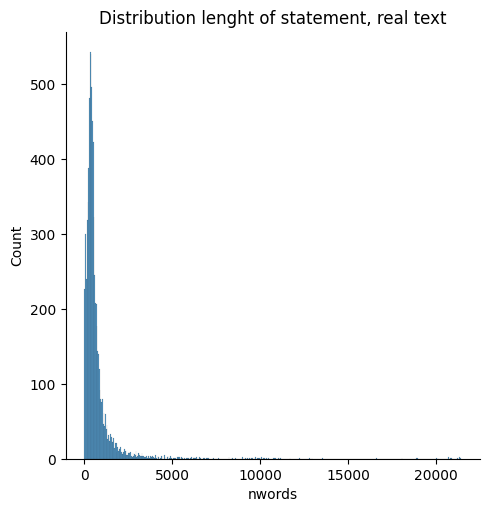

In [44]:
sns.displot(x='nwords', data=real);

plt.title("Distribution lenght of statement, real text");

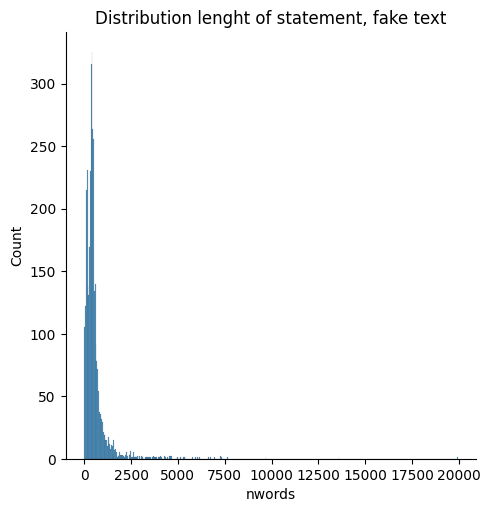

In [45]:
sns.displot(x='nwords', data=fake);

plt.title("Distribution lenght of statement, fake text");

In [46]:
real.describe()

,fake,text_len,title_len,nwords
count,7657.0,7657.000000,7657.000000,7657.000000
mean,0.0,3440.715032,68.343607,708.981716
std,0.0,6217.620199,19.989224,1292.474618
min,0.0,21.000000,4.000000,5.000000
25%,0.0,1342.000000,56.000000,274.000000
50%,0.0,2100.000000,67.000000,433.000000
75%,0.0,3403.000000,81.000000,702.000000
max,0.0,100000.000000,175.000000,21426.000000


In [47]:
fake.describe()

,fake,text_len,title_len,nwords
count,3576.0,3576.000000,3576.000000,3576.000000
mean,1.0,2707.906040,70.092841,557.030761
std,0.0,3770.255239,20.954904,778.688449
min,1.0,27.000000,5.000000,7.000000
25%,1.0,1236.500000,57.000000,252.000000
50%,1.0,1986.000000,69.000000,412.000000
75%,1.0,2830.250000,83.000000,583.000000
max,1.0,100000.000000,200.000000,19932.000000


# baseline model

In [48]:
true = data[data['fake'] == 0].sample(n=3500)
true.shape

(3500, 8)

In [49]:
false = data[data['fake'] == 1].sample(n=3500)
false.shape

(3500, 8)

In [50]:
files = [true, false]

data = pd.concat(files, ignore_index=True)
data.shape

(7000, 8)

In [51]:
X = data['text']
y = data['fake']

In [52]:
# Check the balance of the dataset
round(y.value_counts(normalize = True), 2)

fake
0    0.5
1    0.5
Name: proportion, dtype: float64

In [53]:
# Create a train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

In [54]:
# Create the model pipeline

pipe = make_pipeline(CountVectorizer(), MultinomialNB())
pipe

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [55]:
# Train the pipeline and score

pipe.fit(X_train, y_train)

#pipe.score(X_test, y_test)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [56]:
y_pred = pipe.predict(X_test)

classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.7723214285714286,
  'recall': 0.7554585152838428,
  'f1-score': 0.7637969094922737,
  'support': 687.0},
 '1': {'precision': 0.7692307692307693,
  'recall': 0.7854137447405329,
  'f1-score': 0.7772380291464261,
  'support': 713.0},
 'accuracy': 0.7707142857142857,
 'macro avg': {'precision': 0.770776098901099,
  'recall': 0.7704361300121878,
  'f1-score': 0.77051746931935,
  'support': 1400.0},
 'weighted avg': {'precision': 0.7707473999215071,
  'recall': 0.7707142857142857,
  'f1-score': 0.7706422797161385,
  'support': 1400.0}}

In [ ]:
y_prob=np.round(pipe.predict_proba(X_test),2)
y_prob

In [ ]:
np.unique(y_prob)

In [ ]:
y_prob_df=pd.DataFrame(y_prob)

In [ ]:
y_prob_df.value_counts()

# tests with new data

## isot

In [58]:
#load new data
isot_real=pd.read_csv("/home/kathrin/code/kbank1/fake_news/raw_data/isot/True.csv")
isot_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [60]:
isot_real.shape

(21417, 4)

In [59]:
isot_fake=pd.read_csv("/home/kathrin/code/kbank1/fake_news/raw_data/isot/Fake.csv")
isot_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [61]:
isot_fake.shape

(23481, 4)

Isot is too old and uses politifact -> we might have data leakage.
LIAR is also old and also uses Politifact.

## test with one recent article

In [66]:
X_test

2849    TV host Anne-Marie Losique has again defended ...
1235    Exactly one year ago, Ciara married Russell Wi...
2883    Kelly Rowland is wearing her heart on her hand...
4764    Ed Sheeran did not “break” the “friendship cod...
521     What is Reza Farahan's Net Worth and Salary?\n...
                              ...                        
3438    This content is imported from poll. You may be...
2769    One Monday morning last September, Britain wok...
1246    The singer ignored recent reports he's refusin...
675     CNN —\n\nActor Reg E. Cathey, better known for...
381     On the Today show Tuesday morning, Savannah Gu...
Name: text, Length: 1400, dtype: object

In [73]:
text="US President Donald Trump has offered buyout packages to almost all federal employees, a major move designed to shrink and reform the US government. In an email sent on Tuesday, his administration told workers they had to decide by 6 February whether they wanted to be part of a deferred resignation programme. If they agree by then to quit in September, the message said, they would receive about eight months worth of salary as a severance package. The Trump administration expects up to 10% of employees to accept the offer - which equates to about 200,000 of the more than two million people who work for the federal government, according to the BBCs US partner CBS News. Senior Trump officials told US media that the buyouts could save the government up to $100bn (£80bn). The message from the US Office of Personnel Management (OPM), the governments HR agency, highlighted planned reforms to the government, including a requirement that most employees work in their offices five days a week. Since returning to the White House last week, Trump has already declared the end of Covid-era home working practices. The OPM said the offer was available to all full-time federal employees - excluding certain staff such as postal workers, members of the military, immigration officials, and some national security teams. Workers wishing to take the deal were asked to reply to the email with the word resign in the subject line. The offer includes both pay and benefits for workers until 30 September, and has been described as very generous by the White House. The message also warned of future downsizing that could impact those who chose to stay. We cannot give you full assurance regarding the certainty of your position or agency but should your position be eliminated you will be treated with dignity, it read. Stephen Miller, the White House deputy chief of staff for policy, told CNN that the governments workers were overwhelmingly left of centre, and that it was essential for Trump to get control of government. The move has been condemned. In a statement to US media, the head of the American Federation of Government Employees (AFGE) union warned that this purging process would have vast, unintended consequences that will cause chaos for the Americans who depend on a functioning federal government. Democratic Senator Tim Kaine was among those questioning Trumps power to make such deals. If you accept that offer and resign, hell stiff you just like he stiffed contractors, he said. He doesnt have any authority to do this. Do not be fooled by this guy. The returning US president repeatedly pledged to cut the size of the government and slash federal spending while on the campaign trail. He tasked Elon Musk and Vivek Ramaswamy with leading an advisory body focused on cutting regulations, spending, and headcounts within the federal government. Ramaswamy has since left this new Department of Government Efficiency (Doge). But the email on Tuesday bore resemblance to one sent to employees of Twitter, now X, in late 2022 after Musk bought the social media platform. He asked for an emailed response if they wanted to remain at the company. The mass buyout offer came at the end of an at-times chaotic day in Washington, following a memo Trump issued which said he would pause federal grants, loans and other assistance. A district judge suspended the order - which was initially set to go into effect on Tuesday afternoon - until next Monday. In the hours before that decision, there was widespread confusion over which federal programmes and organisations would be impacted. The White House repeatedly sought to assuage concerns that Social Security payments and Medicaid access could be disrupted.  In a letter to the White House, top Democrats expressed extreme alarm about the plan to pause funding. Also on Tuesday, Trump signed an executive order aimed at restricting gender care for young people. The order, titled Protecting Children from Chemical and Surgical Mutilation, says it would prevent those aged under 19 from making life-altering choices. It is the policy of the United States that it will not fund, sponsor, promote, assist, or support the so-called transition of a child from one sex to another, the order said. It is unclear, however, how the order would be implemented and it is likely to be challenged in court."

In [74]:
df = pd.DataFrame({"text": [text]})

In [76]:
X_test_new=df["text"]

In [77]:
X_test_new

0    US President Donald Trump has offered buyout p...
Name: text, dtype: object

In [78]:
y_pred_new=pipe.predict(X_test_new)

In [80]:
y_pred_new

array([0])

In [93]:
y_prob_new=np.round(pipe.predict_proba(X_test_new),5)
y_prob_new

array([[1., 0.]])

## test with 2023 guardian articles

In [124]:
#import guardian data, test model on 2023 guardian articles
#load new data
guardian=pd.read_csv("/home/kathrin/code/kbank1/fake_news/raw_data/guardian/the_guardian_full.csv")
guardian.tail()

,URL,Title,Description,Content,Time,Tags
187997,https://www.theguardian.com/money/2023/nov/22/...,Seasonal cherrypicker from Chile files unfair ...,Julia Quecaño Casimiro becomes first worker on...,When Julia Quecaño Casimiro left Chile to pick...,Wed 22 Nov 2023 00.00 EST,"['Employment tribunals', 'Employment law', 'Fo..."
187998,https://www.theguardian.com/money/2023/nov/23/...,What is national insurance and who will benefi...,With national insurance at the centre of the a...,A big national insurance cut was the centrepie...,Thu 23 Nov 2023 10.20 EST,"['National insurance', 'Tax', 'Jeremy Hunt', '..."
187999,https://www.theguardian.com/money/2023/nov/23/...,Ofgem energy price cap: what does the new year...,Campaigners say the rise comes at the ‘worst p...,The Ofgem price cap is climbing again and will...,Thu 23 Nov 2023 06.27 EST,"['Energy bills', 'Consumer affairs', 'Househol..."
188000,https://www.theguardian.com/money/2023/nov/23/...,Energy bills in Great Britain to rise by 5% fr...,Ofgem increases maximum price suppliers can ch...,Households will begin the new year with a 5% i...,Thu 23 Nov 2023 04.00 EST,"['Energy bills', 'Energy industry', 'Consumer ..."
188001,https://www.theguardian.com/money/2023/nov/23/...,HP says I should have known its £399 laptop ba...,Then it grabbed it back mid-delivery and is bl...,HP kept emailing me special offers so I checke...,Thu 23 Nov 2023 02.00 EST,"['Consumer rights', 'Your problems, with Anna ..."


In [125]:
#newest articles are on the end
#take the newest 1000
guardian=guardian.tail(1000)

In [126]:
guardian.head()

,URL,Title,Description,Content,Time,Tags
187002,https://www.theguardian.com/football/2023/nov/...,‘I’m old school’: Ange Postecoglou bemoans use...,With Spurs’ 4-1 defeat to Chelsea marked by nu...,Ange Postecoglou said that VAR has made footba...,Mon 6 Nov 2023 18.58 EST,"['Tottenham Hotspur', 'Chelsea', 'Ange Posteco..."
187003,https://www.theguardian.com/football/2023/nov/...,Tottenham’s chaotic derby defeat reveals first...,"While two red cards caused pandemonium, Ange P...",The record books will show that Chelsea won it...,Mon 6 Nov 2023 18.44 EST,"['Tottenham Hotspur', 'Sportblog', 'Chelsea', ..."
187004,https://www.theguardian.com/football/2023/nov/...,Nicolas Jackson hat-trick leads Chelsea past n...,A second-half hat-trick from Nicolas Jackson g...,"After everything that had gone before, it was ...",Mon 6 Nov 2023 17.20 EST,"['Premier League', 'Tottenham Hotspur', 'Chels..."
187005,https://www.theguardian.com/football/2023/nov/...,Champions League roundup: Shakhtar stun Barcel...,Danylo Sikan gave Shakhtar Donetsk a 1-0 win o...,Danylo Sikan’s towering header gave Shakhtar D...,Tue 7 Nov 2023 18.00 EST,"['Champions League', 'European club football',..."
187006,https://www.theguardian.com/football/2023/nov/...,Mikel Arteta goes all in as rage over VAR over...,The Arsenal manager is reluctant to drop his c...,What comes after the doubling down on a positi...,Tue 7 Nov 2023 17.30 EST,"['Arsenal', 'Mikel Arteta', 'Sevilla', 'Europe..."


In [128]:
X_test_new=guardian["Content"]

In [129]:
y_pred_new=pipe.predict(X_test_new)

In [132]:
np.unique(y_pred_new)

array([0, 1])

In [133]:
y_pred_new_df=pd.DataFrame(y_pred_new)

In [137]:
y_pred_new_df.value_counts()

0
0    950
1     50
Name: count, dtype: int64

In [139]:
y_prob_new=np.round(pipe.predict_proba(X_test_new),2)

In [140]:
y_prob_new_df=pd.DataFrame(y_prob_new)

In [144]:
y_prob_new_df.value_counts()

0     1   
1.00  0.00    908
0.00  1.00     27
0.99  0.01     16
0.01  0.99      8
0.98  0.02      4
0.85  0.15      3
0.02  0.98      3
0.95  0.05      3
0.03  0.97      2
0.87  0.13      2
0.23  0.77      2
0.29  0.71      1
0.34  0.66      1
0.04  0.96      1
0.09  0.91      1
0.10  0.90      1
0.26  0.74      1
0.68  0.32      1
0.64  0.36      1
0.63  0.37      1
0.55  0.45      1
0.42  0.58      1
0.37  0.63      1
0.77  0.23      1
0.79  0.21      1
0.92  0.08      1
0.82  0.18      1
0.80  0.20      1
0.81  0.19      1
0.96  0.04      1
0.94  0.06      1
0.93  0.07      1
0.97  0.03      1
Name: count, dtype: int64

## test on politifact data post 2019 (fakenewsnet is from 2018/19)

In [201]:
politifact=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/politifact/politifact_factcheck_data.json", lines=True)

politifact.head()

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...


In [202]:
politifact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21152 entries, 0 to 21151
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   verdict                  21152 non-null  object
 1   statement_originator     21152 non-null  object
 2   statement                21152 non-null  object
 3   statement_date           21152 non-null  object
 4   statement_source         21152 non-null  object
 5   factchecker              21152 non-null  object
 6   factcheck_date           21152 non-null  object
 7   factcheck_analysis_link  21152 non-null  object
dtypes: object(8)
memory usage: 1.3+ MB


In [203]:
politifact['statement_date'] = pd.to_datetime(politifact['statement_date'])

In [204]:
politifact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21152 entries, 0 to 21151
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   verdict                  21152 non-null  object        
 1   statement_originator     21152 non-null  object        
 2   statement                21152 non-null  object        
 3   statement_date           21152 non-null  datetime64[ns]
 4   statement_source         21152 non-null  object        
 5   factchecker              21152 non-null  object        
 6   factcheck_date           21152 non-null  object        
 7   factcheck_analysis_link  21152 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 1.3+ MB


In [205]:
politifact["year"]=politifact["statement_date"].dt.year

In [206]:
politifact.year.value_counts()

year
2020    2112
2012    1942
2011    1898
2016    1757
2021    1668
2010    1574
2014    1548
2013    1419
2018    1375
2019    1355
2015    1290
2017    1275
2022     891
2009     449
2008     438
2007     159
2000       1
2002       1
Name: count, dtype: int64

In [207]:
politifact.verdict.value_counts()

verdict
false           5625
half-true       3597
mostly-false    3432
mostly-true     3332
pants-fire      2703
true            2463
Name: count, dtype: int64

In [208]:
politifact=politifact[politifact["year"]>2019]

In [209]:
politifact.verdict.value_counts()

verdict
false           2299
pants-fire       810
mostly-false     653
half-true        438
mostly-true      280
true             191
Name: count, dtype: int64

In [210]:
politifact= politifact[politifact["verdict"].isin(["false", "pants-fire", "true"])]

In [211]:
politifact["fake"] = 0  # Default to 0
politifact.loc[politifact["verdict"].isin(["false", "pants-fire"]), "fake"] = 1

In [212]:
politifact.head()

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link,year,fake
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",2022-06-07,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...,2022,1
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2021-02-01,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...,2021,1
9,true,Mandela Barnes,"""Since 1978, CEO compensation rose over 1,000%...",2021-05-23,social_media,Madeline Heim,6/2/2021,https://www.politifact.com/factchecks/2021/jun...,2021,0
13,false,Sidney Powell,"""At least 450,000 ballots in the key states .....",2020-11-08,news,Samantha Putterman,11/20/2020,https://www.politifact.com/factchecks/2020/nov...,2020,1
19,false,The Gateway Pundit,"""Newly discovered video shows late night deliv...",2021-02-05,news,Clara Hendrickson,2/5/2021,https://www.politifact.com/factchecks/2021/feb...,2021,1


In [213]:
X_test_new=politifact["statement"]
y_test_new=politifact["fake"]

In [214]:
y_pred_new=pipe.predict(X_test_new)

In [215]:
classification_report(y_test_new, y_pred_new, output_dict=True)

{'0': {'precision': 0.07142857142857142,
  'recall': 0.8900523560209425,
  'f1-score': 0.13224426293271102,
  'support': 191.0},
 '1': {'precision': 0.9771739130434782,
  'recall': 0.28916050176905755,
  'f1-score': 0.4462645817820799,
  'support': 3109.0},
 'accuracy': 0.3239393939393939,
 'macro avg': {'precision': 0.5243012422360248,
  'recall': 0.589606428895,
  'f1-score': 0.28925442235739546,
  'support': 3300.0},
 'weighted avg': {'precision': 0.9247504705439488,
  'recall': 0.3239393939393939,
  'f1-score': 0.4280894663577679,
  'support': 3300.0}}

model is able to detect 89% of the real statements, but only 28% of the fake ones.
the overall accuracy is 32% only.

In [218]:
politifact.verdict.value_counts()

verdict
false         2299
pants-fire     810
true           191
Name: count, dtype: int64

In [219]:
politifact.statement_source.value_counts()

statement_source
social_media     2297
news              334
blog              267
speech            124
advertisement      52
other              49
television         49
radio              36
campaign           34
statement          27
email              11
testimony          11
meeting             9
Name: count, dtype: int64

### test on news only

In [220]:
politifact=politifact[politifact["statement_source"]=="news"]

In [224]:
politifact.verdict.value_counts()

verdict
false         212
pants-fire     65
true           57
Name: count, dtype: int64

In [221]:
X_test_new=politifact["statement"]
y_test_new=politifact["fake"]

In [222]:
y_pred_new=pipe.predict(X_test_new)

In [223]:
classification_report(y_test_new, y_pred_new, output_dict=True)

{'0': {'precision': 0.19391634980988592,
  'recall': 0.8947368421052632,
  'f1-score': 0.31875,
  'support': 57.0},
 '1': {'precision': 0.9154929577464789,
  'recall': 0.23465703971119134,
  'f1-score': 0.3735632183908046,
  'support': 277.0},
 'accuracy': 0.3473053892215569,
 'macro avg': {'precision': 0.5547046537781823,
  'recall': 0.5646969409082272,
  'f1-score': 0.34615660919540225,
  'support': 334.0},
 'weighted avg': {'precision': 0.7923496444159824,
  'recall': 0.3473053892215569,
  'f1-score': 0.36420886674926006,
  'support': 334.0}}